
Problem Statement -
Estimate the phase θ of the phase gate is defined as $P = \begin{bmatrix} 1 & 0 \\ 0 & e^{i 2\pi \theta} \end{bmatrix}$.

corresponding to the eigenvector $\ket{1}$

 where θ= 0.5625 and  0.1234

Implement the Quantum Phase Estimation (QPE) using Quantum Fourier Transform
algorithm to estimate θ. Compute and plot the error vs. number of shots
(log-log plot recommended). Verify whether the convergence rate follows the theoretical
bound:
Error “ Op1{shotsq
Fit a curve to the error plot and compare it with the expected scaling. Also plot the
probability distribution for a suitable number of shots (preferably high shots). Also plot
the variation of error vs. ancilla qubits.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile, assemble
from qiskit_aer import AerSimulator

In [2]:

# QPE Circuit Construction and Inverse QFT

def inverse_qft(n):
    """
    Construct the inverse QFT circuit on n qubits (adjoint of QFT).
    """
    qc = QuantumCircuit(n)
    # Swap qubits to reverse order
    for i in range(n // 2):
        qc.swap(i, n - i - 1)
    # Inverse QFT: apply controlled rotations and Hadamard gates
    for j in range(n):
        for k in range(j):
            qc.cp(-np.pi / (2 ** (j - k)), k, j)
        qc.h(j)
    return qc

def build_qpe_circuit(theta, num_ancilla):
    """
    Build a QPE circuit to estimate the phase of the unitary
    P = diag(1, exp(i2πθ)) acting on the eigenstate |1⟩.
    """
    ancilla = QuantumRegister(num_ancilla, 'ancilla')
    system = QuantumRegister(1, 'system')
    cr = ClassicalRegister(num_ancilla, 'c')
    qc = QuantumCircuit(ancilla, system, cr)
    
    # Prepare ancilla in uniform superposition.
    qc.h(ancilla)
    # Prepare system qubit in eigenstate |1⟩.
    qc.x(system)
    
    # Apply controlled-U^(2^(num_ancilla-1-j)) gates.
    for j in range(num_ancilla):
        exponent = 2 ** (num_ancilla - 1 - j)
        phase = 2 * np.pi * theta * exponent
        qc.cp(phase, ancilla[j], system[0])
    
    # Apply the inverse QFT on the ancilla register.
    qc.append(inverse_qft(num_ancilla), ancilla)
    # Measure the ancilla qubits.
    qc.measure(ancilla, cr)
    return qc

def get_transpiled_qpe(theta, num_ancilla, simulator, optimization_level=3):
    """
    Build and transpile the QPE circuit once to reuse for multiple shot counts.
    """
    qc = build_qpe_circuit(theta, num_ancilla)
    tqc = transpile(qc, simulator, optimization_level=optimization_level)
    return tqc

def estimate_theta_from_counts(counts, num_ancilla):
    """
    Estimate theta from measurement counts by selecting the most common bitstring.
    """
    most_common = max(counts, key=counts.get)
    decimal_value = int(most_common, 2)
    theta_est = decimal_value / (2 ** num_ancilla)
    return theta_est

def run_qpe_experiment(theta, num_ancilla, shots, tqc, simulator):
    """
    Run the QPE experiment using a pre-transpiled circuit.
    
    Args:
        theta (float): True phase.
        num_ancilla (int): Number of ancilla qubits.
        shots (int): Number of shots.
        tqc (QuantumCircuit): Pre-transpiled QPE circuit.
        simulator (AerSimulator): Simulator instance.
    
    Returns:
        float: Estimated phase theta.
        dict: Measurement counts.
    """
    result = simulator.run(tqc, shots=shots).result()
    counts = result.get_counts(tqc)
    theta_est = estimate_theta_from_counts(counts, num_ancilla)
    return theta_est, counts


# Experiment Functions

def experiment_error_vs_shots(theta, num_ancilla, shots_list):
    """
    Run QPE for a list of shot counts and return the absolute errors.
    """
    errors = []
    simulator = AerSimulator()
    # Transpile the circuit once (circuit does not depend on shot count)
    tqc = get_transpiled_qpe(theta, num_ancilla, simulator)
    for shots in shots_list:
        theta_est, _ = run_qpe_experiment(theta, num_ancilla, shots, tqc, simulator)
        error = abs(theta_est - theta)
        # Adjust error on unit circle if necessary
        if error > 0.5:
            error = 1 - error
        errors.append(error)
    return errors

def plot_probability_distribution(theta, num_ancilla, shots):
    """
    Plot the probability distribution (bar chart) for the measured bitstrings.
    """
    simulator = AerSimulator()
    tqc = get_transpiled_qpe(theta, num_ancilla, simulator)
    _, counts = run_qpe_experiment(theta, num_ancilla, shots, tqc, simulator)
    total = sum(counts.values())
    probs = {k: v / total for k, v in counts.items()}
    sorted_keys = sorted(probs.keys(), key=lambda x: int(x, 2))
    sorted_probs = [probs[k] for k in sorted_keys]
    
    plt.figure(figsize=(10, 5))
    plt.bar(sorted_keys, sorted_probs, color='royalblue')
    plt.xticks(rotation=90, fontsize=10, ha="right")
    plt.yticks(fontsize=10)
    plt.xlabel("Measured Bitstring", fontsize=12, fontweight='bold')
    plt.ylabel("Probability", fontsize=12, fontweight='bold')
    plt.title(f"Probability Distribution (shots={shots}, num_ancilla={num_ancilla})", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

def experiment_error_vs_ancilla(theta, ancilla_list, shots):
    """
    Run QPE for different numbers of ancilla qubits (fixed shots) and return errors.
    """
    errors = []
    for num_ancilla in ancilla_list:
        simulator = AerSimulator()
        tqc = get_transpiled_qpe(theta, num_ancilla, simulator)
        theta_est, _ = run_qpe_experiment(theta, num_ancilla, shots, tqc, simulator)
        error = abs(theta_est - theta)
        if error > 0.5:
            error = 1 - error
        errors.append(error)
    return errors


# Main Execution and Plotting

# Define true phase values.
theta_exact = 0.5625  # Exact (binary: 0.1001...)
theta_approx = 0.1234  # Approximate

# Define shots list for Experiment 1 (error vs. shots).
shots_list = np.logspace(2, 4, num=10, dtype=int)  # 100 to 10,000 shots

# Define ancilla counts for Experiment 3 (error vs. ancilla).
ancilla_list = list(range(3, 9))  # from 3 to 8 ancilla qubits


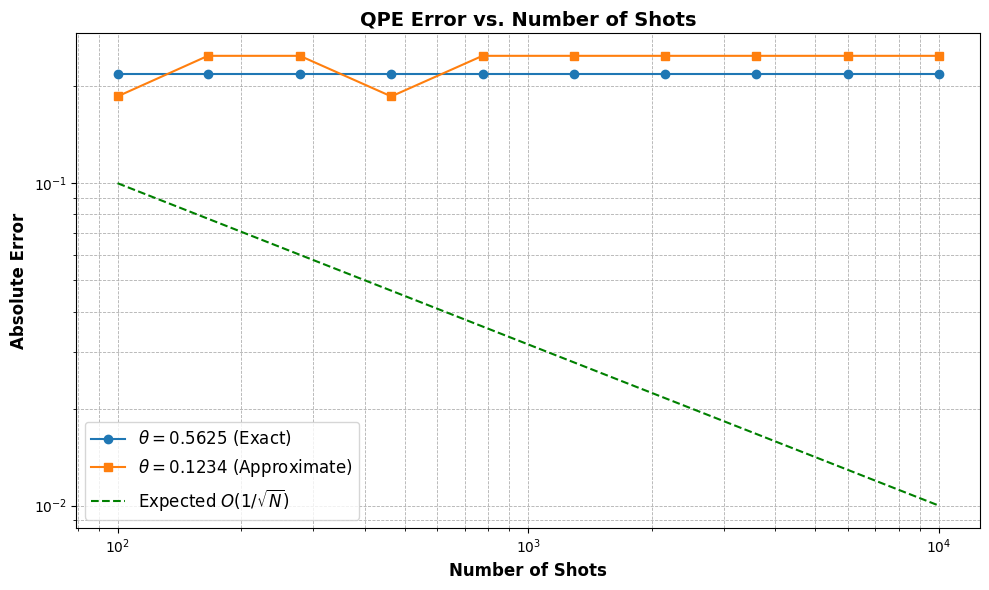

In [3]:
# Experiment 1: Error vs. Shots (using fixed num_ancilla = 5)
num_ancilla = 5
errors_exact = experiment_error_vs_shots(theta_exact, num_ancilla, shots_list)
errors_approx = experiment_error_vs_shots(theta_approx, num_ancilla, shots_list)
theoretical_scaling = 1 / np.sqrt(shots_list)

plt.figure(figsize=(10, 6))
plt.loglog(shots_list, errors_exact, 'o-', label=r'$\theta = 0.5625$ (Exact)')
plt.loglog(shots_list, errors_approx, 's-', label=r'$\theta = 0.1234$ (Approximate)')
plt.loglog(shots_list, theoretical_scaling, 'g--', label=r'Expected $O(1/\sqrt{N})$')
plt.xlabel('Number of Shots', fontsize=12, fontweight='bold')
plt.ylabel('Absolute Error', fontsize=12, fontweight='bold')
plt.title('QPE Error vs. Number of Shots', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.6)
plt.tight_layout()
plt.show()

In [4]:
# Log-log fit for the exact case.
log_shots = np.log(shots_list)
log_errors = np.log(errors_exact)
slope, intercept = np.polyfit(log_shots, log_errors, 1)
print(f"Fitted slope for θ = 0.5625: {slope:.3f} (expected approximately -0.5)")

Fitted slope for θ = 0.5625: 0.000 (expected approximately -0.5)


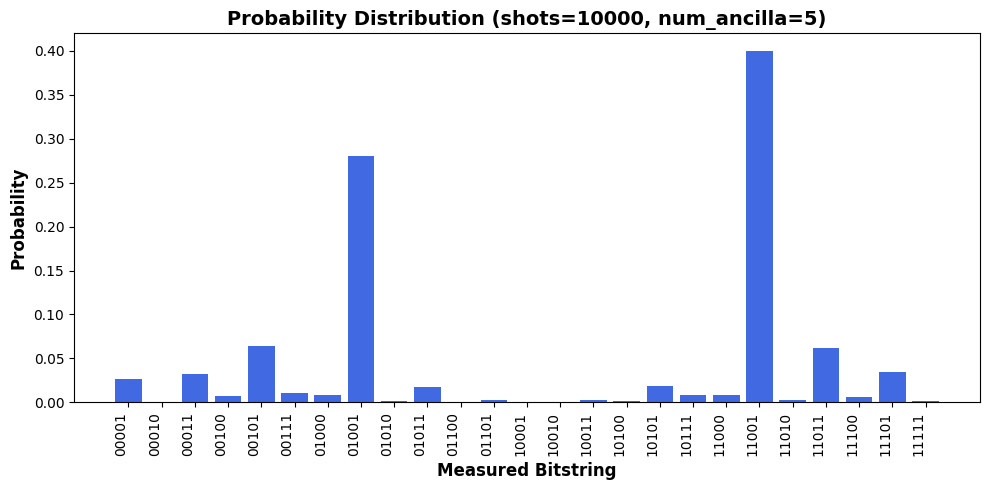

In [5]:
# Experiment 2: Plot Probability Distribution for a high shot count.
plot_probability_distribution(theta_exact, num_ancilla, shots=10000)

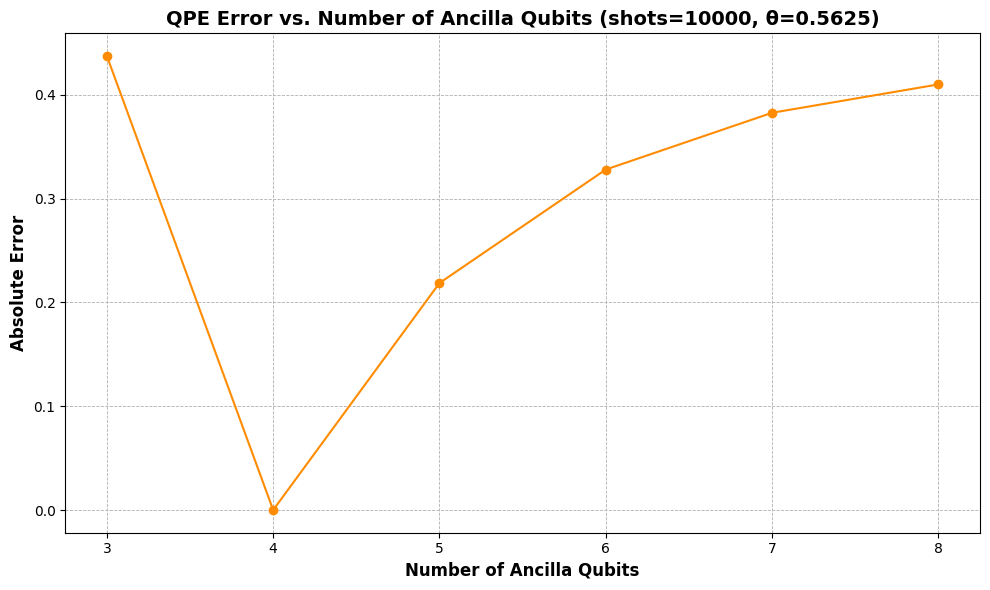

In [6]:
# Experiment 3: Error vs. Number of Ancilla Qubits (with fixed shots).
fixed_shots = 10000
errors_vs_ancilla = experiment_error_vs_ancilla(theta_exact, ancilla_list, fixed_shots)

plt.figure(figsize=(10, 6))
plt.plot(ancilla_list, errors_vs_ancilla, 'o-', color='darkorange')
plt.xlabel('Number of Ancilla Qubits', fontsize=12, fontweight='bold')
plt.ylabel('Absolute Error', fontsize=12, fontweight='bold')
plt.title(f'QPE Error vs. Number of Ancilla Qubits (shots={fixed_shots}, θ={theta_exact})', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', linewidth=0.6)
plt.tight_layout()
plt.show()